In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("the dataset extracted")

the dataset extracted


In [ ]:
import pandas as pd

data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding = 'ISO-8859-1')

In [ ]:
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
column_names =  ['target','id','date','flag','user','text']
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = column_names, encoding = 'ISO-8859-1')


In [ ]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.isnull().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [ ]:
data['target'].value_counts()

,count
target,
0,800000
4,800000


In [ ]:
data.replace({'target' : {4:1}},inplace = True)

In [ ]:
data['target'].value_counts()

,count
target,
0,800000
1,800000


In [ ]:
!pip install emoji regex vaderSentiment textblob transformers datasets spacy scipy optimum[onnxruntime] fastapi uvicorn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU name: Tesla T4


In [ ]:
data = data.iloc[:300000]  # Keep only the first 1000 rows

In [ ]:
data.head()



,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
!pip install swifter

In [ ]:
import re
import emoji
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import swifter  # Parallelized pandas apply()

# Precompile regex patterns
URL_PATTERN = re.compile(r"http\S+")
MENTION_HASHTAG_PATTERN = re.compile(r"@\w+|#(\w+)")
SPECIAL_CHAR_PATTERN = re.compile(r"[^a-zA-Z0-9.!?,;:]+")
CONTRACTIONS = {
    r"won't": "will not", r"can't": "cannot", r"n't": " not",
    r"'re": " are", r"'s": " is", r"'d": " would",
    r"'ll": " will", r"'t": " not", r"'ve": " have", r"'m": " am"
}

# Faster preprocessing function
def preprocess_tweet(text):
    text = emoji.demojize(text, delimiters=(" ", " "))  # Convert emojis
    text = URL_PATTERN.sub("", text)  # Remove URLs
    text = MENTION_HASHTAG_PATTERN.sub(lambda m: m.group(1).replace('_', ' ') if m.group(1) else "", text)  # Remove @, #
    text = SPECIAL_CHAR_PATTERN.sub(" ", text)  # Remove special characters

    for pat, repl in CONTRACTIONS.items():  # Expand contractions
        text = text.replace(pat, repl)

    return text.strip()

# Use swifter for parallelized processing
data['cleaned_text'] = data['text'].swifter.apply(preprocess_tweet)

# Initialize Sentiment Analyzers ONCE (not per row)
vader = SentimentIntensityAnalyzer()

def weak_label(text):
    vader_score = vader.polarity_scores(text)['compound']
    blob_score = TextBlob(text).sentiment.polarity

    if vader_score >= 0.05 and blob_score >= 0.1:
        return "positive"
    elif vader_score <= -0.05 and blob_score <= -0.1:
        return "negative"
    else:
        return "neutral"

# Use swifter for parallelized sentiment analysis
data['weak_label'] = data['cleaned_text'].swifter.apply(weak_label)



# import re
# import emoji
# import pandas as pd
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from textblob import TextBlob

# # Custom preprocessing for Twitter data
# def preprocess_tweet(text):
#     # Convert emojis to text (e.g., 😊 → "smiling_face")
#     text = emoji.demojize(text, delimiters=(" ", " "))

#     # Remove URLs, mentions, and hashtags
#     text = re.sub(r"http\S+|@\w+|#(\w+)", lambda m: m.group(1).replace('_', ' ') if m.group(1) else "", text)

#     # Remove special characters (keep basic punctuation)
#     text = re.sub(r"[^a-zA-Z0-9.!?,;:]", " ", text)

#     # Expand contractions (e.g., "don't" → "do not")
#     contractions = {
#         r"won\'t": "will not", r"can\'t": "cannot", r"n\'t": " not",
#         r"\'re": " are", r"\'s": " is", r"\'d": " would",
#         r"\'ll": " will", r"\'t": " not", r"\'ve": " have", r"\'m": " am"
#     }
#     for pat, repl in contractions.items():
#         text = re.sub(pat, repl, text)

#     return text.strip()

# # Apply preprocessing
# data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# # Generate weak labels using VADER + TextBlob consensus
# def weak_label(text):
#     vader_score = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
#     blob_score = TextBlob(text).sentiment.polarity

#     # Consensus rules (adjust thresholds as needed)
#     if vader_score >= 0.05 and blob_score >= 0.1:
#         return "positive"
#     elif vader_score <= -0.05 and blob_score <= -0.1:
#         return "negative"
#     else:
#         return "neutral"  # Treat as neutral or ambiguous

# data['weak_label'] = data['cleaned_text'].apply(weak_label)

Pandas Apply:   0%|          | 0/300000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/300000 [00:00<?, ?it/s]

In [ ]:
print(data['weak_label'].value_counts())

weak_label
neutral     182631
negative     62822
positive     54547
Name: count, dtype: int64


In [ ]:
data.head()

,target,id,date,flag,user,text,cleaned_text,weak_label
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","Awww, that s a bummer. You shoulda got David C...",neutral
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can t update his Facebook by ...,neutral
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to sa...,positive
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,neutral
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","no, it s not behaving at all. i m mad. why am ...",negative


In [ ]:
data.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text', 'cleaned_text',
       'weak_label'],
      dtype='object')

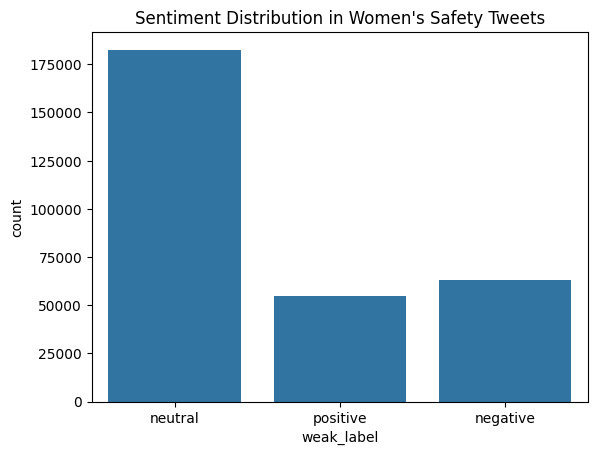

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='weak_label', data=data)
plt.title("Sentiment Distribution in Women's Safety Tweets")
plt.show()

In [ ]:
# Ensure you have enough rows in your 'data' for each class to sample from
positive_data = data[data['weak_label'] == 'positive']
negative_data = data[data['weak_label'] == 'negative']
neutral_data = data[data['weak_label'] == 'neutral']

# Sampling 5000 rows from each sentiment class
positive_test = positive_data.sample(n=5000, random_state=42)
negative_test = negative_data.sample(n=5000, random_state=42)
neutral_test = neutral_data.sample(n=5000, random_state=42)

# Concatenate them to form the test dataset
test_data = pd.concat([positive_test, negative_test, neutral_test])

# Shuffle the test dataset to ensure it's mixed well
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution of the test dataset
print(test_data['weak_label'].value_counts())


weak_label
neutral     5000
negative    5000
positive    5000
Name: count, dtype: int64


In [ ]:
# Ensure you have enough rows in your 'data' for each class to sample from
positive_data = data[data['weak_label'] == 'positive']
negative_data = data[data['weak_label'] == 'negative']
neutral_data = data[data['weak_label'] == 'neutral']

# Sampling 5000 rows from each sentiment class
positive_test = positive_data.sample(n=5000, random_state=42)
negative_test = negative_data.sample(n=5000, random_state=42)
neutral_test = neutral_data.sample(n=5000, random_state=42)

# Concatenate them to form the test dataset
test_data = pd.concat([positive_test, negative_test, neutral_test])

# Shuffle the test dataset to ensure it's mixed well
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution of the test dataset
print(test_data['weak_label'].value_counts())


weak_label
neutral     5000
negative    5000
positive    5000
Name: count, dtype: int64


In [ ]:
test_data.head()

,target,id,date,flag,user,text,cleaned_text,weak_label
0,0,1678385769,Sat May 02 06:32:08 PDT 2009,NO_QUERY,gabek,Mojos on 49th and Dodge went out of business,Mojos on 49th and Dodge went out of business,neutral
1,0,1882408155,Fri May 22 06:49:07 PDT 2009,NO_QUERY,elysion32,@verwon I'm a lil tired from my move yesterday...,I m a lil tired from my move yesterday and wou...,negative
2,0,1979690086,Sun May 31 04:06:33 PDT 2009,NO_QUERY,TheImitableMrJ,"@_micster Dawww, and you were already lonely too","Dawww, and you were already lonely too",neutral
3,0,1573612039,Tue Apr 21 02:00:10 PDT 2009,NO_QUERY,tweetpet,@Mzcertified Clean Me!,Clean Me!,positive
4,0,1693676717,Sun May 03 23:22:05 PDT 2009,NO_QUERY,kiirrrssttyy,@Katherineie probably! we can just move seats...,probably! we can just move seats if they re crap!,negative


In [ ]:
len(test_data)

15000

In [ ]:
import pandas as pd

# Sampling 100,000 rows from each sentiment class and modifying 'data' in place
data = pd.concat([
    data[data['weak_label'] == 'positive'].sample(n=35000, random_state=42),
    data[data['weak_label'] == 'negative'].sample(n=28000, random_state=42),
    data[data['weak_label'] == 'neutral'].sample(n=35000, random_state=42)
])

# Shuffle the dataset to mix samples properly
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Checking the new class distribution
print(data['weak_label'].value_counts())

weak_label
neutral     35000
positive    35000
negative    28000
Name: count, dtype: int64


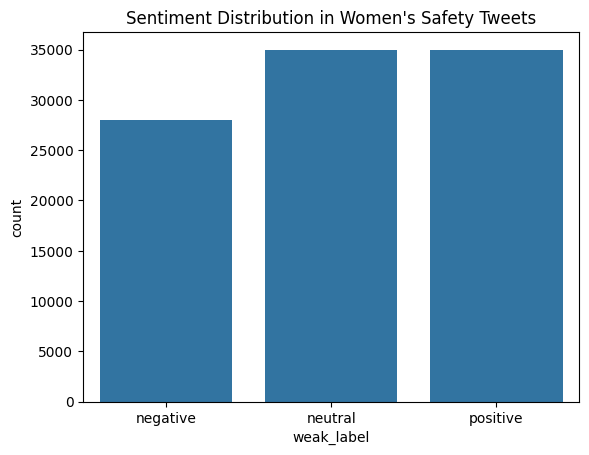

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='weak_label', data=data)
plt.title("Sentiment Distribution in Women's Safety Tweets")
plt.show()

In [ ]:
def split_contrastive_clauses(text):
    clauses = re.split(r"\s+(but|however|although|except)\s+", text, flags=re.IGNORECASE)
    if len(clauses) > 1:
        return [clauses[0], clauses[-1]]  # Return first and last clause
    return [text]

# Example usage:
data['clauses'] = data['cleaned_text'].apply(split_contrastive_clauses)

In [ ]:
# import spacy
# import torch

# # Check if GPU is available
# if torch.cuda.is_available():
#     print("✅ Using GPU for SpaCy!")
#     spacy.require_gpu()
# else:
#     print("⚠️ No GPU detected, running on CPU.")

# # Load Transformer-based SpaCy model for better performance
# nlp = spacy.load("en_core_web_trf", disable=["ner", "textcat"])

# # Optimized function using GPU
# def extract_aspects(texts):
#     aspects_list = []
#     for doc in nlp.pipe(texts, batch_size=5000):  # Use larger batch size for GPU
#         aspects = [chunk.text for chunk in doc.noun_chunks]
#         aspects_list.append(aspects)
#     return aspects_list

# # Convert text column to list and process in batch mode
# data['aspects'] = extract_aspects(data['cleaned_text'].tolist())



# import spacy

# # Load spaCy model once (not inside function)
# nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])  # Disable unused components for speed

# # Use nlp.pipe() for batch processing
# def extract_aspects(texts):
#     aspects_list = []
#     for doc in nlp.pipe(texts, batch_size=1000, n_process=4):  # Multi-threading enabled
#         aspects = [chunk.text for chunk in doc.noun_chunks]
#         aspects_list.append(aspects)
#     return aspects_list

# # Apply optimized batch processing
# data['aspects'] = extract_aspects(data['cleaned_text'].tolist())


import spacy
nlp = spacy.load("en_core_web_sm")

def aspect_sentiment(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

data['aspects'] = data['cleaned_text'].apply(aspect_sentiment)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
data.head()

,target,id,date,flag,user,text,cleaned_text,weak_label,clauses,aspects
0,0,1991636366,Mon Jun 01 07:23:50 PDT 2009,NO_QUERY,nancienne,my feet hurt so uncomfortable!,my feet hurt so uncomfortable!,negative,[my feet hurt so uncomfortable!],[my feet]
1,0,1991257693,Mon Jun 01 06:42:16 PDT 2009,NO_QUERY,mistabaka,@bgbg85 it crashed (via @breakingnews),it crashed via,neutral,[it crashed via],[it]
2,0,1753505824,Sun May 10 01:59:09 PDT 2009,NO_QUERY,hayleyy_j,misses him. yet he is just out having fun..,misses him. yet he is just out having fun..,positive,[misses him. yet he is just out having fun..],"[him, he, fun]"
3,0,1880791546,Fri May 22 02:31:08 PDT 2009,NO_QUERY,Ranus,Wish I'd bought those Pink tickets now! 8 mont...,Wish I d bought those Pink tickets now! 8 mont...,positive,[Wish I d bought those Pink tickets now! 8 mon...,"[I, those Pink tickets, 8 months preggers, a g..."
4,0,1833982500,Mon May 18 01:10:41 PDT 2009,NO_QUERY,Hyperopia,"@ladybug8320 Good morning hun, from a wet and ...","Good morning hun, from a wet and windy Sheffield",positive,"[Good morning hun, from a wet and windy Sheffi...","[Good morning hun, a wet and windy Sheffield]"


In [ ]:
len(data)

98000

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using {device} for training!")

# Ensure weak_label is numeric
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
data["weak_label"] = data["weak_label"].map(label_mapping)

# Split data into train/validation
train_df, val_df = train_test_split(data, test_size=0.1, stratify=data["weak_label"], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Load Twitter-optimized model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["cleaned_text"],  # Ensure "cleaned_text" exists in DataFrame
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Ensure labels are in dataset
train_dataset = train_dataset.map(lambda examples: {"labels": examples["weak_label"]})
val_dataset = val_dataset.map(lambda examples: {"labels": examples["weak_label"]})

# Load model with correct label size
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # 3 sentiment classes
    ignore_mismatched_sizes=True
).to(device)  # Move to GPU

# Training arguments (Optimized for T4 GPU)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,  # Increased for better performance
    per_device_train_batch_size=64,  # Higher batch size for T4 GPU
    per_device_eval_batch_size=128,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=2e-5,
    warmup_ratio=0.06,  # Gradual warm-up
    weight_decay=0.01,
    fp16=True,  # Mixed precision for faster training
    gradient_checkpointing=True,  # Reduces memory usage
    gradient_accumulation_steps=4,  # Simulate larger batch size
    optim="adamw_torch",  # Faster optimizer
    save_total_limit=2,  # Prevents too many saved checkpoints
    report_to="none"  # Disable WandB logging in Colab
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train model
trainer.train()







# from transformers import (
#     AutoTokenizer,
#     AutoModelForSequenceClassification,
#     Trainer,
#     TrainingArguments
# )
# a;lkdfjs
# from datasets import Dataset
# from sklearn.model_selection import train_test_split

# # Ensure weak_label is numeric
# label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
# data["weak_label"] = data["weak_label"].map(label_mapping)

# # Split data into train/validation (reset index to avoid index issues)
# train_df, val_df = train_test_split(data, test_size=0.1, stratify=data["weak_label"])
# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)

# # Convert to Hugging Face Dataset
# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)

# # Load Twitter-optimized model
# model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# def tokenize_function(examples):
#     return tokenizer(
#         examples["cleaned_text"],  # Change to "text" if needed
#         padding="max_length",
#         truncation=True,
#         max_length=128,
#         return_special_tokens_mask=True
#     )

# # Apply tokenization
# train_dataset = train_dataset.map(tokenize_function, batched=True)
# val_dataset = val_dataset.map(tokenize_function, batched=True)

# # Ensure labels are present in dataset
# train_dataset = train_dataset.map(lambda examples: {"labels": examples["weak_label"]})
# val_dataset = val_dataset.map(lambda examples: {"labels": examples["weak_label"]})

# # Load model
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=3,  # positive/negative/neutral
#     ignore_mismatched_sizes=True
# )

# # Training configuration
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=3,
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=64,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     fp16=True,
#     gradient_accumulation_steps=2,
#     logging_steps=100,
#     learning_rate=2e-5
# )

# # Train
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
# )

# trainer.train()

✅ Using cuda for training!


Map:   0%|          | 0/88200 [00:00<?, ? examples/s]

Map:   0%|          | 0/9800 [00:00<?, ? examples/s]

Map:   0%|          | 0/88200 [00:00<?, ? examples/s]

Map:   0%|          | 0/9800 [00:00<?, ? examples/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss
1,0.342700,0.294484
2,0.262700,0.257211
3,0.185600,0.227363


TrainOutput(global_step=1376, training_loss=0.2886688653812852, metrics={'train_runtime': 2399.9284, 'train_samples_per_second': 147.004, 'train_steps_per_second': 0.573, 'total_flos': 2.314713981120307e+16, 'train_loss': 0.2886688653812852, 'epoch': 3.9891225525743295})

In [ ]:
trainer.save_model("./final_trained_model");

In [ ]:
import os
print(os.listdir("./results"))

['checkpoint-1376', 'checkpoint-1035']


In [ ]:
data.head()

,target,id,date,flag,user,text,cleaned_text,weak_label,clauses,aspects
0,0,1991636366,Mon Jun 01 07:23:50 PDT 2009,NO_QUERY,nancienne,my feet hurt so uncomfortable!,my feet hurt so uncomfortable!,0,[my feet hurt so uncomfortable!],[my feet]
1,0,1991257693,Mon Jun 01 06:42:16 PDT 2009,NO_QUERY,mistabaka,@bgbg85 it crashed (via @breakingnews),it crashed via,1,[it crashed via],[it]
2,0,1753505824,Sun May 10 01:59:09 PDT 2009,NO_QUERY,hayleyy_j,misses him. yet he is just out having fun..,misses him. yet he is just out having fun..,2,[misses him. yet he is just out having fun..],"[him, he, fun]"
3,0,1880791546,Fri May 22 02:31:08 PDT 2009,NO_QUERY,Ranus,Wish I'd bought those Pink tickets now! 8 mont...,Wish I d bought those Pink tickets now! 8 mont...,2,[Wish I d bought those Pink tickets now! 8 mon...,"[I, those Pink tickets, 8 months preggers, a g..."
4,0,1833982500,Mon May 18 01:10:41 PDT 2009,NO_QUERY,Hyperopia,"@ladybug8320 Good morning hun, from a wet and ...","Good morning hun, from a wet and windy Sheffield",2,"[Good morning hun, from a wet and windy Sheffi...","[Good morning hun, a wet and windy Sheffield]"


In [ ]:
len(data)

98000

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch
from datasets import Dataset

# ✅ Ensure test data has correct labels
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
test_data["weak_label"] = test_data["weak_label"].map(label_mapping)

# ✅ Convert test data to Hugging Face Dataset format
test_dataset = Dataset.from_pandas(test_data)

# ✅ Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=512, padding="max_length")

# ✅ Apply tokenization
test_dataset = test_dataset.map(tokenize_function, batched=True)

# ✅ Ensure labels are mapped correctly
test_dataset = test_dataset.map(lambda examples: {"labels": examples["weak_label"]})

# ✅ Predict using your trained model
predictions = trainer.predict(test_dataset).predictions

# ✅ Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# ✅ Convert numerical labels back to text labels
id_to_label = {0: "negative", 1: "neutral", 2: "positive"}
test_data["predicted_label"] = [id_to_label[pred] for pred in predicted_labels]
test_data["actual_label"] = [id_to_label[label] for label in test_data["weak_label"]]

# ✅ Generate Classification Report
print(classification_report(test_data["actual_label"], test_data["predicted_label"]))

# ✅ Save results
test_data.to_csv("test_results.csv", index=False)
print("✅ Test dataset evaluation completed & results saved successfully!")

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.93      0.96      0.94      5000
     neutral       0.90      0.87      0.88      5000
    positive       0.94      0.94      0.94      5000

    accuracy                           0.92     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.92      0.92      0.92     15000

✅ Test dataset evaluation completed & results saved successfully!


In [ ]:
# ✅ Save model and tokenizer together
trainer.save_model("./final_trained_model")
tokenizer.save_pretrained("./final_trained_model")

print("✅ Model & tokenizer saved successfully!")

✅ Model & tokenizer saved successfully!


In [ ]:
import shutil
from google.colab import files

# Zip the model directory
shutil.make_archive('final_trained_model', 'zip', './final_trained_model')

# Download the zipped model
files.download('final_trained_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ✅ Load model & tokenizer
model_path = "./final_trained_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# ✅ Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Process input text
input_text = "I love coding!"  # Replace with your text
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(device)

# ✅ Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# ✅ Convert logits to probabilities
logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)

# ✅ Get predicted label
predicted_label = torch.argmax(probs, dim=-1).item()

# ✅ Map label to sentiment
label_map = {0: "negative", 1: "neutral", 2: "positive"}
predicted_sentiment = label_map[predicted_label]

print(f"\nInput Text: {input_text}")
print(f"Predicted Sentiment: {predicted_sentiment} (Confidence: {probs[0][predicted_label]:.4f})")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Input Text: I love coding!
Predicted Sentiment: positive (Confidence: 0.9992)
